## Adding the Dolfinx library to the colab environment

In [ ]:
 !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"

## Adding the Gmsh library to the colab environment

In [ ]:
!wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"

## Importing the required libraries

In [ ]:
from mpi4py import MPI
from dolfinx import mesh, fem, io, plot, nls, log, geometry, la
from dolfinx import cpp as _cpp
from dolfinx import default_real_type
import basix
import dolfinx.fem.petsc
import ufl
import numpy as np
from petsc4py.PETSc import ScalarType
from petsc4py import PETSc
import time
import random
import os
import gmsh

log.set_log_level(log.LogLevel.ERROR)
comm = MPI.COMM_WORLD
comm_rank = MPI.COMM_WORLD.rank

## Setting material properties and geometry dimensions
We are considering a 10% variation in $S_{hs}$.

In [ ]:
# Material properties
E, nu = ScalarType(0.15142), ScalarType(0.4995)	                                  #Young's modulus and Poisson's ratio
mu, lmbda, kappa = E/(2*(1 + nu)), E*nu/((1 + nu)*(1 - 2*nu)), E/(3*(1 - 2*nu))
Gc= ScalarType(0.075)	                                                            #Critical energy release rate
sts, scs= ScalarType(0.24), ScalarType(0.308571)	                                #Tensile strength and compressive strength
shs1 = (2/3)*sts*scs/(scs-sts)
Wts = sts**2/(2*E)


var = 0.1
shs2 = shs1*(1+var)
shs3 = shs1*(1-var)
Whs1 = shs1**2/(2*kappa)
Whs2 = shs2**2/(2*kappa)
Whs3 = shs3**2/(2*kappa)

# Irwin characteristic length
lch=3*Gc*E/8/(sts**2)
# The regularization length
eps=0.02                                                                          #epsilon should not be chosen to be too large compared to lch. Typically eps<4*lch should work

# Geometry
W, L = 12.5, 0.625
h=eps/5

## Generating the mesh and refine to $h=\frac{ϵ}{5}$
We also save the mesh in xdmf format.

In [ ]:
gmsh.initialize()
gmsh.model.add("Pokerchip")
gmsh.model.setCurrent("Pokerchip")

rectangle_dim_tags = gmsh.model.occ.addRectangle(0,0,0, W, L)
gmsh.model.occ.synchronize()

# Add physical tag 1 for exterior surfaces
boundary = gmsh.model.getBoundary([(2, rectangle_dim_tags)])
boundary_ids = [b[1] for b in boundary]
gmsh.model.addPhysicalGroup(1, boundary_ids, tag=1)
gmsh.model.setPhysicalName(1, 1, "boundary of rectangle")

# Add physical tag 2 for the volume
volume_entities = [model[1] for model in gmsh.model.getEntities(2)]
gmsh.model.addPhysicalGroup(2, volume_entities, tag=2)
gmsh.model.setPhysicalName(2, 2, "rectangle area")

# Generating Mesh
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",h)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",h)
gmsh.model.mesh.generate(2)
gmsh.model.mesh.setOrder(1)

domain, cell_markers, facet_markers = io.gmshio.model_to_mesh(gmsh.model, comm, comm_rank, gdim=2)

gmsh.finalize()
with io.XDMFFile(domain.comm, f"out_gmsh/mesh_rank_{MPI.COMM_WORLD.rank}.xdmf", "w") as file:
    file.write_mesh(domain)
    domain.topology.create_connectivity(domain.topology.dim - 1, domain.topology.dim)

## Defining the function spaces

In [ ]:
hel=ufl.FacetArea(domain)                                                         #area/length of a cell facet on a given mesh
h_avg = (hel('+') + hel('-')) / 2.0
n=ufl.FacetNormal(domain)

V = fem.functionspace(domain, ("CR", 1, (domain.geometry.dim,)))                  #Function space for u
Vplot = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim,)))        #Function space for plotting u
Y = fem.functionspace(domain, ("Lagrange", 1))                                    #Function space for z
DG_zero = fem.functionspace(domain, ("DG", 0))                                    #Function space for external phase-field force constants

## Creating the load expressions

In [ ]:
maxdisp=0.0625*0.01
class MyExpression:
    def __init__(self):
        self.t = 0.0
        self.disp = maxdisp

    def eval(self, x):
        values = np.zeros((2, x.shape[1]))
        values[1,:] = self.disp*self.t

        return values

class MyExpression2:
    def __init__(self):
        self.t = 0.0
        self.disp = maxdisp
        self.tau = 0

    def eval(self, x):
        values = np.zeros((2, x.shape[1]))
        values[1,:] = self.disp*(self.t-self.tau)

        return values

re = MyExpression()
re.t = 0
r = fem.Function(V)
r.interpolate(re.eval)

r0e = MyExpression2()
r0e.t = 0
r0 = fem.Function(V)
r0.interpolate(r0e.eval)


c = ScalarType(0)
c2 = ScalarType((0.0,0.0))

## Setting the Dirichlet boundary conditions

In [ ]:
def left(x):
    return np.isclose(x[0], 0)

def right(x):
    return np.isclose(x[0], W)

def bottom(x):
    return np.isclose(x[1], 0)

def top(x):
    return np.isclose(x[1], L)

fdim = domain.topology.dim -1
left_facets = mesh.locate_entities_boundary(domain, fdim, left)
right_facets = mesh.locate_entities_boundary(domain, fdim, right)
bottom_facets = mesh.locate_entities_boundary(domain, fdim, bottom)
top_facets = mesh.locate_entities_boundary(domain, fdim, top)

dofs_left = fem.locate_dofs_topological(V.sub(0), fdim, left_facets)
dofs_bottom = fem.locate_dofs_topological(V, fdim, bottom_facets)
dofs_top = fem.locate_dofs_topological(V, fdim, top_facets)


bcl = fem.dirichletbc(c, dofs_left, V.sub(0))
bcb = fem.dirichletbc(c2, dofs_bottom, V)
bct = fem.dirichletbc(r, dofs_top)
bcs = [bcl, bcb, bct]


dofs_top_z = fem.locate_dofs_topological(Y, fdim, top_facets)
dofs_bottom_z = fem.locate_dofs_topological(Y, fdim, bottom_facets)

cz=ScalarType(1.0)
bct_z = fem.dirichletbc(cz, dofs_top_z, Y)
bcb_z = fem.dirichletbc(cz, dofs_bottom_z, Y)
bcs_z=[bct_z, bcb_z]

d_du = ScalarType((0.0,0.0))
bct_du = fem.dirichletbc(d_du, dofs_top, V)
bct_du0 = fem.dirichletbc(r0, dofs_top)

bcs_du = [bcl, bcb, bct_du]
bcs_du0 = [bcl, bcb, bct_du0]

d_dz=ScalarType(0.0)
bct_dz = fem.dirichletbc(d_dz, dofs_top_z, Y)
bcb_dz = fem.dirichletbc(d_dz, dofs_bottom_z, Y)
bcs_dz=[bct_dz, bcb_dz]

# Dofs on which reaction is calculated
y_dofs_top = fem.locate_dofs_topological(V.sub(1), fdim, top_facets)

## Marking the facets and defining trial and test functions

In [ ]:
marked_facets = np.hstack([bottom_facets, top_facets, left_facets])
marked_values = np.hstack([np.full_like(bottom_facets, 1),
                           np.full_like(top_facets, 2),
                           np.full_like(left_facets, 3)])
sorted_facets = np.argsort(marked_facets)
facet_tag = mesh.meshtags(domain, domain.topology.dim -1,
                          marked_facets[sorted_facets],
                          marked_values[sorted_facets])

metadata = {"quadrature_degree": 4}
ds = ufl.Measure('ds', domain=domain,
                 subdomain_data=facet_tag, metadata=metadata)
dS = ufl.Measure("dS", domain=domain, metadata=metadata)
dx = ufl.Measure("dx", domain=domain, metadata=metadata)



########################################################################
# Define functions
########################################################################
du = ufl.TrialFunction(V)                                                         # Incremental displacement
v  = ufl.TestFunction(V)                                                          # Test function for u
u  = fem.Function(V)                                                              # Displacement from previous iteration
uplot = fem.Function(Vplot)                                                       # Displacement for the plot
u_inc = fem.Function(V)
dz = ufl.TrialFunction(Y)                                                         # Incremental phase field
y  = ufl.TestFunction(Y)                                                          # Test function
z  = fem.Function(Y)                                                              # Phase field from previous iteration
z_inc = fem.Function(Y)
d = len(u)                                                                        # Dimension
B  = fem.Constant(domain, (0.0, 0.0))                                             # Body force per unit volume
Tr  = fem.Constant(domain, (0.0,  0.0))                                           # Traction force on the boundary


## Setting the initial conditions

In [ ]:
##############################################################
#Initialisation of displacement field,u and the phase field,z
##############################################################
u.x.array[:] = 0.
fem.petsc.set_bc(u.vector, bcs)

z.x.array[:] = 1.
fem.petsc.set_bc(z.vector, bcs_z)

z_ub = fem.Function(Y)
z_ub.x.array[:] = 1.
z_lb = fem.Function(Y)
z_lb.x.array[:] = 0.

u_prev = fem.Function(V)
u_prev.x.array[:] = u.x.array
z_prev = fem.Function(Y)
z_prev.x.array[:] = z.x.array

## Creating stochastic functions for $\delta^{ϵ}$, $\alpha_1$ and $\alpha_2$
We are using the new model to calculate the $\delta^{ϵ}$. At the end, we save the $\alpha_1$ and $\alpha_2$, in xdmf files

In [ ]:
# Stochasticity in shs
elem_p = domain.topology.index_map(domain.topology.dim).size_local
numelem = int(comm.reduce(elem_p, op=MPI.SUM, root=0))
randvalues=np.random.choice(3, numelem)

delta1 = (1+3*h/(8*eps))**(-2) * ((sts + (1+2*np.sqrt(3))*shs1)/((8+3*np.sqrt(3))*shs1)) * 3*Gc/(16*Wts*eps) + (1+3*h/(8*eps))**(-1) * (2/5)
delta2= (1+3*h/(8*eps))**(-2) * ((sts + (1+2*np.sqrt(3))*shs2)/((8+3*np.sqrt(3))*shs2)) * 3*Gc/(16*Wts*eps) + (1+3*h/(8*eps))**(-1) * (2/5)
delta3= (1+3*h/(8*eps))**(-2) * ((sts + (1+2*np.sqrt(3))*shs3)/((8+3*np.sqrt(3))*shs3)) * 3*Gc/(16*Wts*eps) + (1+3*h/(8*eps))**(-1) * (2/5)


deltaarray = [delta1, delta2, delta3]

alpha1array = [(delta1*Gc)/(shs1*8*eps) - (2*Whs1)/(3*shs1),
               (delta2*Gc)/(shs2*8*eps) - (2*Whs2)/(3*shs2),
               (delta3*Gc)/(shs3*8*eps) - (2*Whs3)/(3*shs3)]
alpha2array = [(3**0.5*(3*shs1 - sts)*delta1*Gc)/(shs1*sts*8*eps) + (2*Whs1)/(3**0.5*shs1) - (2*3**0.5*Wts)/(sts),
               (3**0.5*(3*shs2 - sts)*delta2*Gc)/(shs2*sts*8*eps) + (2*Whs2)/(3**0.5*shs2) - (2*3**0.5*Wts)/(sts),
               (3**0.5*(3*shs3 - sts)*delta3*Gc)/(shs3*sts*8*eps) + (2*Whs3)/(3**0.5*shs3) - (2*3**0.5*Wts)/(sts)]
indexlist=[0,1,2]
patchsize=0.1

for i in range(MPI.COMM_WORLD.size):
    randvalues_indices= random.choices(indexlist, k=int(1.1*W/patchsize)*int(1.1*L/patchsize))
    randvalues_delta = np.array([deltaarray[i] for i in randvalues_indices])
    randvalues_alpha1 = np.array([alpha1array[i] for i in randvalues_indices])
    randvalues_alpha2 = np.array([alpha2array[i] for i in randvalues_indices])

def delt(x):
    values = np.zeros((1, x.shape[1]))
    for col_idx in range(x.shape[1]):
        values[0,col_idx] = randvalues_delta[int(1.1*L/patchsize)*
                                             int(x[0,col_idx]//patchsize)+
                                             int(x[1,col_idx]//patchsize)]
    return values


delta = fem.Function(DG_zero)
delta.interpolate(delt)


def alph1(x):
    values = np.zeros((1, x.shape[1]))
    for col_idx in range(x.shape[1]):
        values[0,col_idx] = randvalues_alpha1[int(1.1*L/patchsize)*
                                             int(x[0,col_idx]//patchsize)+
                                             int(x[1,col_idx]//patchsize)]
    return values


alpha1 = fem.Function(DG_zero)
alpha1.interpolate(alph1)

def alph2(x):
    values = np.zeros((1, x.shape[1]))
    for col_idx in range(x.shape[1]):
        values[0,col_idx] = randvalues_alpha2[int(1.1*L/patchsize)*
                                             int(x[0,col_idx]//patchsize)+
                                             int(x[1,col_idx]//patchsize)]
    return values

alpha2 = fem.Function(DG_zero)
alpha2.interpolate(alph2)

with io.XDMFFile(domain.comm, "alpha1.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    alpha1.name = "alpha1"
    xdmf.write_function(alpha1)

with io.XDMFFile(domain.comm, "alpha2.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    alpha2.name = "alpha2"
    xdmf.write_function(alpha2)

## Defining a function to do a interpolation for any field

In [ ]:
def local_project(v, V):
    """[summary]
        Helper function to do a interpolation
    Args:
        v ([dolfin.Funcion]): [function to be projected]
        V ([dolfin.Function]): [target `dolfin.FunctionSpace` to be projected on]

    Returns:
        [dolfin.Function]: [target function after projection]
    """
    expr = fem.Expression(v, V.element.interpolation_points())
    u = fem.Function(V)
    u.interpolate(expr)
    return u

## Defining Strain Energy, strain and stress functions
We also add the weak form of PDE for displacement

In [ ]:
# Strain Energy, strain and stress functions in linear isotropic elasticity (plane strain)

def energy(v):
    return mu*(ufl.inner(ufl.sym(ufl.grad(v)),ufl.sym(ufl.grad(v)))) + 0.5*(lmbda)*(ufl.tr(ufl.sym(ufl.grad(v))))**2

def epsilon(v):
    return ufl.sym(ufl.grad(v))

def sigma(v):
    return 2.0*mu*ufl.sym(ufl.grad(v)) + (lmbda)*ufl.tr(ufl.sym(ufl.grad(v)))*ufl.Identity(len(v))


def sigmavm(sig,v):
    return ufl.sqrt(1/2*(ufl.inner(sig-1/3*(1+nu)*ufl.tr(sig)*ufl.Identity(len(v)), sig-1/3*(1+nu)*ufl.tr(sig)*ufl.Identity(len(v))) + ((2*nu/3-1/3)**2)*ufl.tr(sig)**2 ))

eta = 1e-6
# Stored strain energy density
psi1 = (z**2+eta)*(energy(u))
psi11 = energy(u)
Pi = psi1*dx

# Compute first variation of Pi (directional derivative about u in the direction of v)
R1 = ufl.derivative(Pi, u, v)
R2 = (5.0/h_avg)*ufl.inner(ufl.jump(u),ufl.jump(v))*dS
R = R1 + R2

# Compute Jacobian of R
Jac1 = ufl.derivative(R1, u, du)
Jac2 = ufl.derivative(R2, u, du)
Jac = Jac1+Jac2
Jac3 = ufl.inner(ufl.grad(du),ufl.grad(v))*dx

A2 = fem.assemble_matrix(fem.form(Jac2));
A3 = fem.assemble_matrix(fem.form(Jac3));

## Defining the external force $c_{e}$ in the phase-field equation

In [ ]:
I1 = (z**2)*(1+nu)*ufl.tr(sigma(u))
SQJ2 = (z**2)*sigmavm(sigma(u),u)
ce = alpha2*SQJ2 + alpha1*I1 - z*(1-ufl.sqrt(I1**2)/I1)*psi11

## Weak form of PDE for phase-field

In [ ]:
#Balance of configurational forces PDE
pen=1000*(3*Gc/8/eps)*ufl.conditional(ufl.lt(delta,1),1, delta)
Wv=pen/2*((abs(z)-z)**2 + (abs(1-z) - (1-z))**2 )*dx

R_z = y*2*z*(psi11)*dx + y*(ce)*dx + 3*delta*Gc/8*(-y/eps + 2*eps*ufl.inner(ufl.grad(z),ufl.grad(y)))*dx + ufl.derivative(Wv,z,y)

# Compute Jacobian of R_z
Jac_z = ufl.derivative(R_z, z, dz)

## Create PETSc Krylov solvers

In [ ]:
# Set solver options
opts = PETSc.Options()
opts["ksp_type"] = "cg"
opts["ksp_rtol"] = 1.0e-10
opts["pc_type"] = "gamg"

# Create PETSc Krylov solver and turn convergence monitoring on
solver_u = PETSc.KSP().create(domain.comm)
#solver_u.getPC().setType(PETSc.PC.Type.HYPRE)
#solver_u.getPC().setHYPREType("boomeramg")
max_iterations=450
solver_u.setFromOptions()
solver_u.setIterationNumber(max_iterations)

solver_z = PETSc.KSP().create(domain.comm)
#solver_z.getPC().setType(PETSc.PC.Type.HYPRE)
#solver_z.getPC().setHYPREType("boomeramg")
solver_z.setFromOptions()
solver_z.setIterationNumber(max_iterations)

## Setting the time step parameters

In [ ]:
# time-stepping parameters
T=1
Totalsteps=500
minstepsize=1/Totalsteps/10000
maxstepsize=1/Totalsteps*1
stepsize=1/Totalsteps
t=stepsize
step=1
samesizecount=1
# Other time stepping parameters
terminate=0
terminate2=0
gfcount=0
nrcount=0
printsteps=10                                                                     #Number of incremental steps after which solution will be stored
rtol=1e-6
nostagiter=2

tau=0

## Solving the problem over several time steps via a staggered scheme

In [ ]:
start_time=time.time()
# Solve variational problem
while t-stepsize < T:

    if terminate2==0:
        omega=1e6
    else:
        printsteps=10
        rtol=1e-6
        gfcount+=1
        if omega>1e6:
            omega=1e6

    if gfcount>10:
        gfcount=0
        omega*=10

    if comm_rank==0:
        print('Step= %d' %step, 't= %e' %t, 'Stepsize= %e' %stepsize)

    re.t=t; r0e.t=t; r0e.tau=tau
    r.interpolate(re.eval)
    r0.interpolate(r0e.eval)

    stag_iter=1
    rnorm_stag=1
    while stag_iter<nostagiter+1 and rnorm_stag > 1e-6:

        ##############################################################
        # PDE for u
        ##############################################################

        terminate=0
        ## Newton iterations ##################################
        nIter = 0
        rnorm = 1000.0
        rnorm_prev=1000.0

        while nIter < 20:
            nIter += 1

            if nIter>15 and terminate2==0:
                terminate=1
                break


            if terminate2==1:
                if omega<1e3:
                    if nIter<5:
                        solver_u.setIterationNumber(500)
                    else:
                        solver_u.setIterationNumber(150)
                else:
                    if nIter<15:
                        solver_u.setIterationNumber(450)
                    else:
                        solver_u.setIterationNumber(250)



            if nIter==1 and stag_iter==1:
                a = fem.form(Jac+(1/omega)*Jac3)
                A = fem.petsc.assemble_matrix(a, bcs=bcs_du0)
                A.assemble()
                b = fem.petsc.assemble_vector(fem.form(-R))
                fem.petsc.apply_lifting(b, [a], bcs=[bcs_du0])
                b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
                fem.petsc.set_bc(b, bcs_du0)
            else:
                a = fem.form(Jac+(1/omega)*Jac3)
                A = fem.petsc.assemble_matrix(a, bcs=bcs_du)
                A.assemble()
                b = fem.petsc.assemble_vector(fem.form(-R))
                fem.petsc.apply_lifting(b, [a], bcs=[bcs_du])
                b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
                fem.petsc.set_bc(b, bcs_du)

            rnorm=b.norm()


            if comm_rank==0:
                print('Iteration number for u= %d' %nIter,  'Residual= %e' %rnorm)

            if rnorm < rtol:             #residual check
                break

            if rnorm > rnorm_prev*50 or (np.isnan(rnorm)==True):
                terminate=1
                break

            if nIter==15 and rnorm>1e0:
                terminate=1
                break


            rnorm_prev=rnorm


            start_time=time.time()
            solver_u.setOperators(A)
            solver_u.solve(b, u_inc.vector)
            u_inc.x.scatter_forward()

            if comm_rank==0:
                print("--- %s seconds ---" % (time.time() - start_time))

            u.vector.axpy(1.0, u_inc.vector)
            u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)


        ####################################################

        if terminate==1:
            break

        ##############################################################
        # PDE for z
        ##############################################################
        start_time=time.time()

        ## Newton iterations ##################################
        nIter = 0
        rnorm = 1000.0
        rnorm_prev=1000.0


        while nIter < 20:
            nIter += 1

            if nIter>10:
                break
            az = fem.form(Jac_z)
            Az = fem.petsc.assemble_matrix(az, bcs=bcs_dz)
            Az.assemble()
            bz = fem.petsc.assemble_vector(fem.form(-R_z))
            fem.petsc.apply_lifting(bz, [az], bcs=[bcs_dz])
            bz.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
            fem.petsc.set_bc(bz, bcs_dz)

            rnorm=bz.norm()

            if comm_rank==0:
                print('Iteration number for z= %d' %nIter,  'Residual= %e' %rnorm)

            if rnorm < 1e-8:             #residual check
                break


            if step>1:
                if rnorm > rnorm_prev*1e4 or (np.isnan(rnorm)==True):             #residual check
                    terminate=1
                    break

            rnorm_prev=rnorm

            solver_z.setOperators(Az)
            solver_z.solve(bz, z_inc.vector)
            z_inc.x.scatter_forward()

            z.vector.axpy(1.0, z_inc.vector)
            z.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)


        zmin = domain.comm.allreduce(np.min(z.x.array), op=MPI.MIN)


        if comm_rank==0:
            print(zmin)

        if comm_rank==0:
            print("--- %s seconds ---" % (time.time() - start_time))


        ###############################################################
        #Residual check for stag loop
        ###############################################################
        b = fem.petsc.assemble_vector(fem.form(-R))

        fint=b.copy()
        fem.petsc.set_bc(b, bcs_du)

        rnorm_stag=b.norm()
        stag_iter+=1


    ######################################################################
    # Post-Processing
    if terminate==1:
        u.x.array[:] = u_prev.x.array
        z.x.array[:] = z_prev.x.array
    else:
        u_prev.x.array[:] = u.x.array
        z_prev.x.array[:] = z.x.array
        tau+=stepsize
        #### Calculate Reaction
        Fx=domain.comm.allreduce(np.sum(fint[y_dofs_top]), op=MPI.SUM)

        if comm_rank==0:
            print(Fx)
            with open('Reaction_Ratio40eps2.txt', 'a') as rfile:
                rfile.write("%s %s %s %s\n" % (str(t),str(t*maxdisp), str(Fx), str(zmin)))

        #### Plot solution on incremental steps

        if step % printsteps==0:
            uplot.x.array[:] = (local_project(u, Vplot)).x.array
            uplot.name = "displacement field"
            z.name = "phase field"
            with io.XDMFFile(domain.comm, "paraview/2D_Ratio40checkeps2_" + str(step) + ".xdmf", "w") as file_results:
                file_results.write_mesh(domain)
                file_results.write_function(uplot, t)
                file_results.write_function(z, t)


    #time stepping
    if terminate==1:
        if stepsize>minstepsize:
            t-=stepsize
            stepsize/=2
            t+=stepsize
            samesizecount=1
            if gfcount>0:
                gfcount-=1
            omega*=0.1
            if terminate2==0:
                nrcount+=1
            if nrcount>3:
                terminate2=1
                nrcount=0
        else:
            break
    else:


        if samesizecount<2:
            step+=1
            if t+stepsize<=T:
                samesizecount+=1
                t+=stepsize
            else:
                samesizecount=1
                stepsize=T-t
                t+=stepsize

        else:
            step+=1
            if stepsize*2<=maxstepsize and t+stepsize*2<=T:
                stepsize*=2
                t+=stepsize
            elif stepsize*2>maxstepsize and t+maxstepsize<=T:
                stepsize=maxstepsize
                t+=stepsize
            else:
                stepsize=T-t
                t+=stepsize
            samesizecount=1

## Results

Here, we have the normalized force vs stretch plot and two snap-shots of the deformed configuration showing the nucleated cracks.

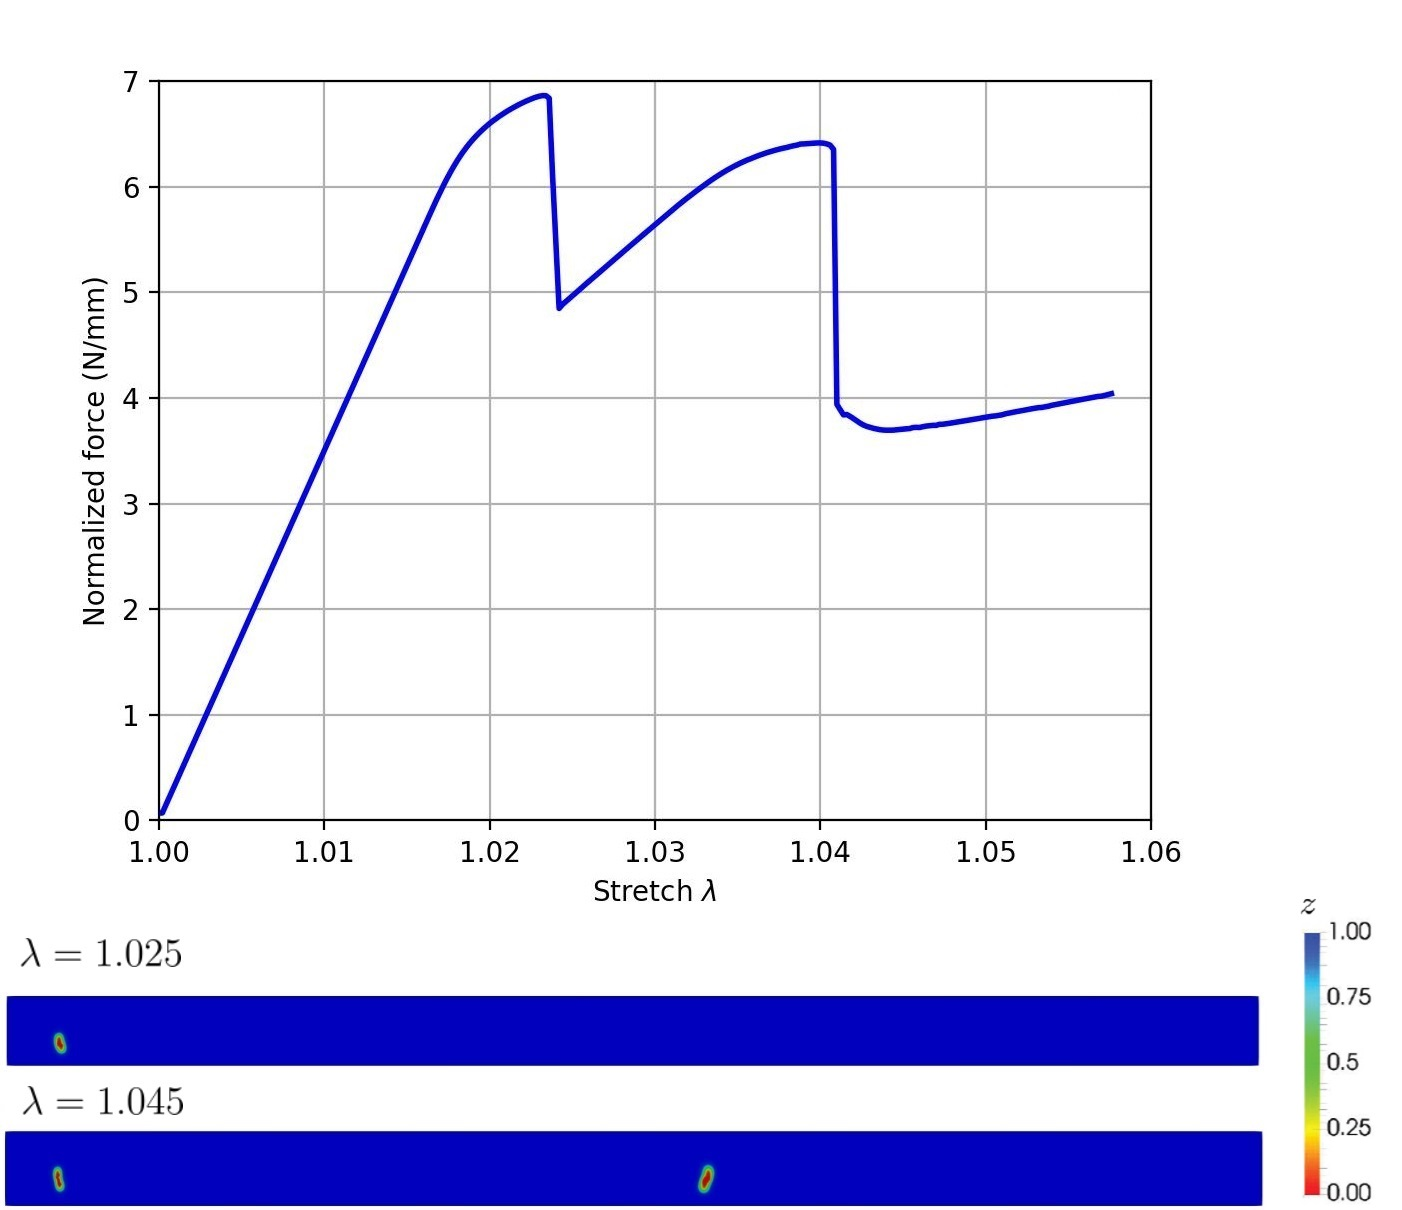